### Deep Learning Homework 4

1. Now that you have all the tools to train an MLP with high performance on MNIST, try reaching 0-loss (or 100% accuracy) on the training data (with a small epsilon, e.g. 99.99% training performance -- don't worry if you overfit!). The implementation is completely up to you. You just need to keep it an MLP without using fancy layers (e.g., keep the Linear layers, don't use Conv1d or something like this, don't use attention). You are free to use any LR scheduler or optimizer, any one of batchnorm/groupnorm, regularization methods... If you use something we haven't seen during lectures, please motivate your choice and explain (as briefly as possible) how it works.
2. Try reaching 0-loss on the training data with permuted labels. Assess the model on the test data (without permuted labels) and comment. Tip: To permute the labels, act on the trainset.targets with an appropriate torch function. Then, you can pass this "permuted" Dataset to a DataLoader like so: trainloader_permuted = torch.utils.data.DataLoader(trainset_permuted, batch_size=batch_size_train, shuffle=True). You can now use this DataLoader inside the training function. Additional view for motivating this exercise: 

In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import pylab as pl
from IPython.display import clear_output
import seaborn as sns
sns.set_theme()


# Training and other functions
from scripts import *

In [8]:
# 1. Achieve 99.99% train set accuracy

# Define the model
class MLP(nn.Module):
    """
    Implements a neural network to train on MNIST 
    """
    def __init__(self):
        super().__init__()
        self.layers = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(784, 100),
            torch.nn.ReLU(),
            torch.nn.Linear(100,100),
            torch.nn.ReLU(),
            torch.nn.Linear(100,10)
        )
        
    def forward(self, X):        
        return self.layers(X)

In [49]:
# Load the data
import torchvision
from torchvision.transforms import Compose, ToTensor, Normalize

# Change root_dir to the directory where to find MNIST
root_dir = '../data/'
transforms = Compose([
    ToTensor(),
    Normalize((0.1307,), (0.3081,))
    ])

# Training and test sets
train_set = torchvision.datasets.MNIST(root=root_dir, train=True, transform=transforms)
test_set = torchvision.datasets.MNIST(root=root_dir, train=False, transform=transforms)

# Create train and test loaders
batch_train, batch_test = 64, 512
train_loader = DataLoader(train_set, batch_size=batch_train, shuffle=True, num_workers=2)
test_loader = DataLoader(test_set, batch_size=batch_test, shuffle=False, num_workers=2)

In [45]:
def train_model(model, train_set, criterion, optimizer, n_epochs, 
                val_set=None, val_criterion=None, scheduler=None):    
    """
    Trains a model, can keep track of learning metrics on validation set
    and implements early stopping
    
    Parameters
    ----------
    model: nn.Module
        Model to train
    
    train_set: DataLoader
        Training set
        
    criterion: loss function
        Loss function criterion
    
    optimizer: torch optimizer
        Optimizer to use to train the model
    
    n_epochs: int
        Number of epochs to train the model
    
    val_set: DataLoader
        Validation set to keep track of the generalization error, Default: None
    
    val_criterion: loss function with signature f(model, val_set) -> float
        Evaluation criterion on the test set, Default: Same as criterion
        
    scheduler: torch.optim.lr_scheduler
        Learning rate scheduler, default: None
        
    Returns
    -------
    float: 
        Loss on the training epoch
    """
    train_losses = []
    train_accuracies = []
    val_accuracies = []
        
    for epoch in range(n_epochs):
        print(f"\nEpoch: {epoch}") 
        
        # Model training
        train_loss = train_epoch(model, train_set, criterion, optimizer)
        train_losses.append(train_loss)
        print(f"Train loss: {train_loss}")
        
        # Train accuracy
        train_accuracy = 1-eval_model(model, train_set, val_criterion)
        train_accuracies.append(train_accuracy)
        print(f"Train accuracy: {train_accuracy}")
        
        # Test accuracy
        val_accuracy = 1-eval_model(model, val_set, val_criterion)
        val_accuracies.append(val_accuracy)
        print(f"Validation accuracy: {val_accuracy}")
        
        # Step the scheduler
        scheduler.step(1-train_accuracy)
        
    return train_losses, train_accuracies, val_accuracies
    

In [9]:
# Train with Cross entropy and Adam optimizer
net = MLP()
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters())
# I added a scheduler to help Adam reach maximum accuracy on train data
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=4)
_, train_accuracies, val_accuracies = train_model(net, train_loader, loss, optimizer, n_epochs=30, 
                                                  val_set=test_loader, val_criterion=accuracy, scheduler=scheduler)
clear_output()

In [17]:
train_accuracies[-1], val_accuracies[-1]

(1.0, 0.9840999999582768)

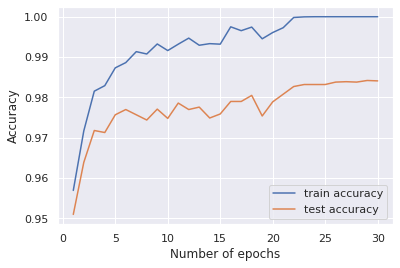

In [11]:
epochs = list(range(1,31))
pl.plot(epochs, train_accuracies, label="train accuracy")
pl.plot(epochs, val_accuracies, label="test accuracy")
pl.ylabel("Accuracy")
pl.xlabel("Number of epochs")
pl.legend()
pl.show()

We see that after epoch 23 the train accuracy reaches values very close to 1 and by epoch 30 it reached 1, this is expected since our model has over 70k parameters and the training set is composed of 50k examples. Another very interesting result is that the test accuracy follows very closely the behaviour of the training accuracy, even when the model is obviously overfitting the data the generalization error still decreases.

In [52]:
# 2. Achieve 99.99% train set accuracy on a training set with permuted labels

# Create a training set with permuted labels
from copy import deepcopy

def shuffle(x):
    return x[torch.randperm(x.size()[0])]

train_set_permuted = deepcopy(train_set)
train_set_permuted.targets = shuffle(train_set_permuted.targets)

train_loader_permuted = DataLoader(train_set_permuted, batch_size=batch_train,
                                   shuffle=True, num_workers=2)

In [53]:
# Train with Cross entropy and Adam optimizer
net = MLP()
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters())
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=4)
_, train_accuracies, val_accuracies = train_model(net, train_loader_permuted, loss, optimizer, n_epochs=30, 
                                                  val_set=test_loader, val_criterion=accuracy, scheduler=scheduler)
clear_output()


Epoch: 0
Train loss: 2.3026954345703126
Train accuracy: 0.10716666666666663


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc9031e51f0>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fc9031e51f0>
Traceback (most recent call last):
  File "/home/lettera/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1324, in __del__
Traceback (most recent call last):
  File "/home/lettera/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/home/lettera/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
      File "/home/lettera/anaconda3/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
self._shutdown_workers()    assert self._parent_pid == os.getpid(), 'can only test a child process'

  File "/home/lettera/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
AssertionError: ca

Validation accuracy: 0.05500000019073481

Epoch: 1


KeyboardInterrupt: 

In [ ]:
epochs = list(range(1,51))
pl.plot(epochs, train_losses, label="train accuracy")
pl.plot(epochs, test_losses, label="test accuracy")
pl.ylabel("Accuracy")
pl.xlabel("number of epochs")
pl.legend()
pl.show()